In [1]:
from optimizers import *
from functions import *
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable

## A simple function

$$M = 3, K = 2, p \in \R^M, \forall_{0 \leq i < N} \, x^{[i]} \in \R^K, \, y^{[i]} \in \R$$

$$f : \R^K \times \R^M \to \R, \qquad f(x, p) = p_0^3 x_0 + p_1 x_1 + p_2 $$

$$ D_pf(x, p) = \left[\frac{\partial f}{\partial p_0}(x, p), \frac{\partial f}{\partial p_1}(x, p), \frac{\partial f}{\partial p_2}(x, p)\right]^T = [3p_0^2x_0, x_1, 1]^T$$

$$ R : \R^M \to \R^N, \qquad R(p) = \left[f(x^{[i]}, p) - y^{[i]}\right]_{0 \leq i < N} $$

$$ DR(p) = \left[\frac{\partial f}{\partial p_j}(x^{[i]}, p)\right]_{0 \leq i < N, 0 \leq j < M}$$

In [3]:
xs = np.array([[1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7]])
ys = np.array([1, 2, 3, 4, 5, 6])


def f(x: np.ndarray, p: np.ndarray) -> np.ndarray:
    assert x.shape == (2,)
    assert p.shape == (3,)

    return p[0]**3 * x[0] + p[1] * x[1] + p[2]


def df(x: np.ndarray, p: np.ndarray) -> np.ndarray:
    assert x.shape == (2,)
    assert p.shape == (3,)

    return np.array([3 * p[0]**2 * x[0], x[1], 1])

def ddf(x: np.ndarray, p: np.ndarray) -> np.ndarray:
    assert x.shape == (2,)
    assert p.shape == (3,)

    return np.array([[6 * p[0] * x[0], 0, 0], [0, 0, 0], [0, 0, 0]])


def residue(
    f: Callable[[np.ndarray, np.ndarray], np.ndarray],
    xs: np.ndarray,
    ys: np.ndarray,
    p: np.ndarray,
) -> np.ndarray:
    assert xs.shape[1] == 2, f"{xs.shape=}"
    assert xs.shape[0] == ys.shape[0]
    assert p.shape == (3,)

    fs = np.array([f(x, p) for x in xs])

    return fs - ys


def residue_jacobian(
    df: Callable[[np.ndarray, np.ndarray], np.ndarray],
    ys: np.ndarray,
    xs: np.ndarray,
    p: np.ndarray,
) -> np.ndarray:
    assert xs.shape[1] == 2
    assert xs.shape[0] == ys.shape[0]
    assert p.shape == (3,)

    dfs = np.array([df(x, p) for x in xs])

    return np.array([dfs[i] for i in range(len(xs))])

def residue_hessian(
    ddf: Callable[[np.ndarray, np.ndarray], np.ndarray],
    ys: np.ndarray,
    xs: np.ndarray,
    p: np.ndarray,
) -> np.ndarray:
    assert xs.shape[1] == 2
    assert xs.shape[0] == ys.shape[0]
    assert p.shape == (3,)

    ddfs = np.array([ddf(x, p) for x in xs])

    return np.array([ddfs[i] for i in range(len(xs))])

In [4]:
def R_value(p: np.ndarray) -> np.ndarray:
    return residue(f, xs, ys, p)

def R_derivative(p: np.ndarray) -> np.ndarray:
    return residue_jacobian(df, ys, xs, p)

def R_hessian(p: np.ndarray) -> np.ndarray:
    return residue_hessian(ddf, ys, xs, p)

F = Function(R_value, R_derivative, R_hessian, 3, 6)

## Performence tests

Running Newton


Newton:   0%|          | 0/500 [00:00<?, ?it/s]

Newton: 100%|██████████| 500/500 [00:00<00:00, 4387.41it/s]


Running Gauss-Newton


Gauss-Newton: 100%|██████████| 500/500 [00:00<00:00, 9262.30it/s]


Running Gradient descent


Gradient descent: 100%|██████████| 500/500 [00:00<00:00, 13893.30it/s]


Running Levenberg-Marquardt (const)


Levenberg-Marquardt: 100%|██████████| 500/500 [00:00<00:00, 7355.41it/s]


Running Levenberg-Marquardt (changing)


Levenberg-Marquardt: 100%|██████████| 500/500 [00:00<00:00, 2689.04it/s]


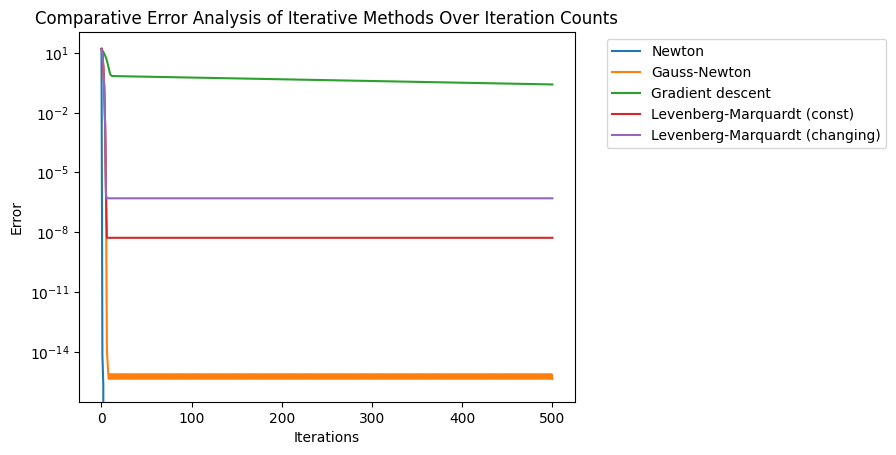

In [5]:
M = 3
max_iter = 500
p0 = np.random.randn(M)
alpha_gd = 1e-3
alpha_gn = 1.0
lambda0 = 1e-2
lambda_change = 1.1
step_max_iter = 10
step_tol = 1e-6

NEWTON = "Newton"
GAUSS_NEWTON = "Gauss-Newton"
GRADIENT_DESCENT = "Gradient descent"
LEVENBERG_MARQUARDT_CONST_PARAM = "Levenberg-Marquardt (const)"
LEVENBERG_MARQUARDT_MODIFYING_PARAM = "Levenberg-Marquardt (changing)"
optimizer_names = [
    NEWTON,
    GAUSS_NEWTON,
    GRADIENT_DESCENT,
    LEVENBERG_MARQUARDT_CONST_PARAM,
    LEVENBERG_MARQUARDT_MODIFYING_PARAM,
]

errors = {name: [] for name in optimizer_names}
points = {name: [] for name in optimizer_names}

optimizer_functions = {
    NEWTON: lambda points, errs: newton(R=F, p0=p0, max_iter=max_iter, alpha=alpha_gn, points=points, errs=errs),
    GAUSS_NEWTON: lambda points, errs: gauss_newton(R=F, p0=p0, alpha=alpha_gn, max_iter=max_iter, points=points, errs=errs),
    GRADIENT_DESCENT: lambda points, errs: gradient_descent(R=F, p0=p0, alpha=alpha_gd, max_iter=max_iter, points=points, errs=errs),
    LEVENBERG_MARQUARDT_CONST_PARAM: lambda points, errs: (
        LevenbergMarquardt(R=F, lambda_param_fun=LevenbergMarquardt.LambdaParamConstant(lambda0=lambda0))
        .optimize(p0, max_iter, step_type="cgnr", step_max_iter=step_max_iter, step_tol=step_tol, points=points, errs=errs)
    ),
    LEVENBERG_MARQUARDT_MODIFYING_PARAM: lambda points, errs: (
        LevenbergMarquardt(R=F, lambda_param_fun=LevenbergMarquardt.LambdaParamDefaultModifier(lambda0=lambda0, lambda_change=lambda_change))
        .optimize(p0, max_iter, step_type="cgnr", step_max_iter=step_max_iter, step_tol=step_tol, points=points, errs=errs)
    ),
}

for name, optimizer in optimizer_functions.items():
    print("Running " + name)
    optimizer(points=points[name], errs=errors[name])

iters = np.arange(0, max_iter + 1)
for label, err in errors.items():
    try:
        plt.plot(iters, err, label=label)
    except:
        print("error in plotting for " + label)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Iterations")
plt.ylabel("Error")
plt.yscale("log")
plt.title("Comparative Error Analysis of Iterative Methods Over Iteration Counts")
plt.show()

## WIP

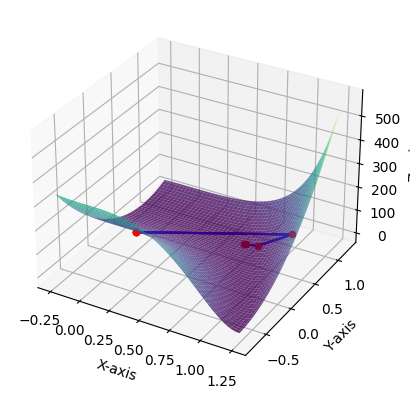

In [30]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def normF(x: np.ndarray) -> np.float64:
    return np.linalg.norm(F(x))**2

def update(frame, data, line):
    scatter = ax.scatter(data[frame, 0], data[frame, 1], normF(data[frame]), c='r', marker='o')
    line = ax.plot(data[:frame+1, 0], data[:frame+1, 1], np.array([normF(x) for x in data[:frame+1]]), 'b-')[0]
    return scatter, line


# Set up the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')  # Use projection='3d' directly

# Generate data for x, y, and z
Xs = np.linspace(-0.25, 1.25, 100)
Ys = np.linspace(-0.75, 1.25, 100)

Xs, Ys = np.meshgrid(Xs, Ys)
Zs = np.array([[normF(np.array([x, y, 0])) for x, y in zip(xrow, yrow)] for xrow, yrow in zip(Xs, Ys)])
# TODO [x, y, 0]

# Plot the surface
ax.plot_surface(Xs, Ys, Zs, cmap='viridis', alpha=0.8)

# Add labels and title
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
# ax.set_title('3D Plot of a Function')

# trajectory = np.array(points[GRADIENT_DESCENT])[:10]
trajectory = np.array(points[GAUSS_NEWTON])[:5]
iters = len(trajectory)

# Create an initial line plot
line = ax.plot([], [], [], 'b')[0]

# Create the animation
ani = FuncAnimation(fig, update, frames=iters, fargs=(trajectory, line), blit=True)

# Save the animation as a GIF
# ani.save('gradient_descent_convergence_3d.gif', writer='imagemagick', fps=5)

# Display the plot (optional)
# plt.show()

# run the animation
HTML(ani.to_jshtml())